In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.path.abspath(""),"../python")))

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

import table_utils as tu

CENSOR_DATE = pd.to_datetime('2022-11-28')


In [2]:
dfw = pd.read_pickle("../../intermediate/data_main.pkl")

C:\Users\ekung\AppData\Local\Temp\ipykernel_9928\914376399.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])


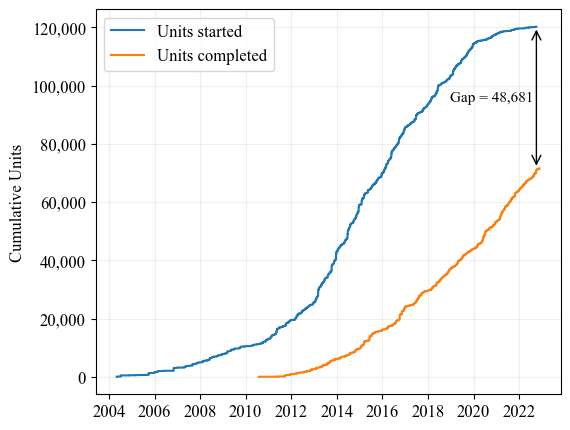

In [3]:
# Unit completion over time: gap

plot_df1 = dfw.groupby('START_DATE').agg(TOTAL_ADDED=('DU_CHANGED','sum')).reset_index().sort_values(by='START_DATE', ascending=True)
plot_df1['CUM_ADDED'] = plot_df1['TOTAL_ADDED'].cumsum()

plot_df2 = dfw.groupby('COFO_DATE').agg(TOTAL_ADDED=('DU_CHANGED','sum')).reset_index().sort_values(by='COFO_DATE', ascending=True)
plot_df2['CUM_ADDED'] = plot_df2['TOTAL_ADDED'].cumsum()

gaptop = (plot_df1['START_DATE'].iloc[-1], plot_df1['CUM_ADDED'].iloc[-1])
gapbot = (plot_df1['START_DATE'].iloc[-1], plot_df2['CUM_ADDED'].iloc[-1])
gap = gaptop[1] - gapbot[1]
gapmid = (plot_df1['START_DATE'].iloc[-1], gapbot[1] + 0.5*gap)

plt.figure(figsize=(6,5))
plt.rc('axes', labelsize=12)
plt.step(plot_df1['START_DATE'], plot_df1['CUM_ADDED'])
plt.step(plot_df2['COFO_DATE'], plot_df2['CUM_ADDED'])
plt.annotate(text='', xy=gaptop, xytext=gapbot, arrowprops=dict(arrowstyle='<->', mutation_scale=16))
plt.annotate(text=f"Gap = {gap:,.0f}", xy=gapmid, xytext=(-2,0), fontsize=11, textcoords='offset points', ha='right', va='center')
plt.ylabel('Cumulative Units')
#plt.xlabel('YEAR')
plt.legend(['Units started', 'Units completed'])
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])
plt.grid(alpha=0.2)
plt.gca().set_axisbelow(True)
plt.savefig('../../results/fig_opportunity1.svg', bbox_inches='tight')
plt.show()


C:\Users\ekung\AppData\Local\Temp\ipykernel_9928\4267588880.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])


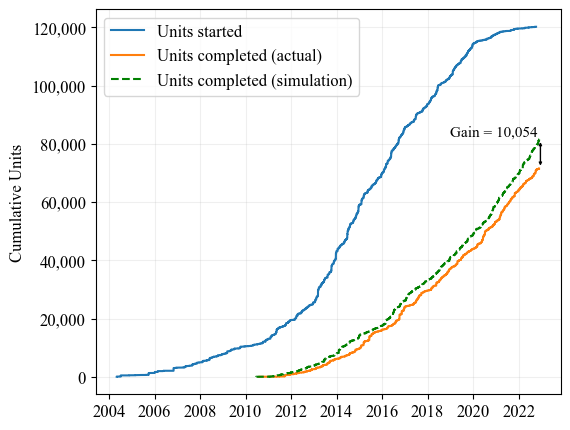

Gain in affordable units: 1,136 (12.6% gain over baseline of 9,039)
Gain in market-rate units: 8,918 (14.3% gain over baseline of 62,493)


In [11]:
# Simulation: reducing approval time by 25%

dfsim = pd.read_csv("../../intermediate/data_basic_sim.csv")
dfsim = dfsim.merge(dfw, on='PERMIT_NBR', how='left')

# simualte the COFO date
dfsim['SIMULATED_COFO'] = dfsim['START_DATE'] + pd.to_timedelta(dfsim['SIMULATED_TOTAL_TIME'], unit='D')
dfsim.loc[ dfsim['SIMULATED_COFO'] > CENSOR_DATE, 'SIMULATED_COFO'] = pd.NA


plot_df1 = dfsim.groupby('START_DATE').agg(TOTAL_ADDED=('DU_CHANGED','sum')).reset_index().sort_values(by='START_DATE', ascending=True)
plot_df1['CUM_ADDED'] = plot_df1['TOTAL_ADDED'].cumsum()

plot_df2 = dfsim.groupby('COFO_DATE').agg(TOTAL_ADDED=('DU_CHANGED','sum')).reset_index().sort_values(by='COFO_DATE', ascending=True)
plot_df2['CUM_ADDED'] = plot_df2['TOTAL_ADDED'].cumsum()

plot_df3 = dfsim.groupby('SIMULATED_COFO').agg(TOTAL_ADDED=('DU_CHANGED','sum')).reset_index().sort_values(by='SIMULATED_COFO', ascending=True)
plot_df3['CUM_ADDED'] = plot_df3['TOTAL_ADDED'].cumsum()

gapx = plot_df1['START_DATE'].iloc[-1] + pd.to_timedelta(70, unit='D')
gaptop = (gapx, plot_df3['CUM_ADDED'].iloc[-1])
gapbot = (gapx, plot_df2['CUM_ADDED'].iloc[-1])
gap = gaptop[1] - gapbot[1]
gapmid = (gapx, gapbot[1] + 0.5*gap)

plt.figure(figsize=(6,5))
plt.rc('axes', labelsize=12)
plt.step(plot_df1['START_DATE'], plot_df1['CUM_ADDED'])
plt.step(plot_df2['COFO_DATE'], plot_df2['CUM_ADDED'])
plt.step(plot_df3['SIMULATED_COFO'], plot_df3['CUM_ADDED'], linestyle='dashed', color='green')
plt.annotate(text='', xy=gaptop, xytext=gapbot, arrowprops=dict(arrowstyle='<->', mutation_scale=4))
plt.annotate(text=f"Gain = {gap:,.0f}", xy=gapmid, xytext=(-2,16), fontsize=11, textcoords='offset points', ha='right', va='center')
plt.ylabel('Cumulative Units')
plt.legend(['Units started', 'Units completed (actual)', 'Units completed (simulation)'])
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])
plt.grid(alpha=0.2)
plt.gca().set_axisbelow(True)
plt.savefig('../../results/fig_opportunity3.svg', bbox_inches='tight')
plt.show()

AFFBASE = dfw.loc[ dfw['COFO_DATE'].notnull(), 'AFFORDABLE_UNITS'].sum()
AFFSIM = dfsim.loc[ dfsim['SIMULATED_COFO']<=CENSOR_DATE, 'AFFORDABLE_UNITS'].sum()
AFFGAIN = AFFSIM - AFFBASE
print(f"Gain in affordable units: {AFFGAIN:,.0f} ({AFFGAIN/AFFBASE*100:,.1f}% gain over baseline of {AFFBASE:,.0f})")

MKTBASE = dfw.loc[ dfw['COFO_DATE'].notnull(), 'MARKETRATE_UNITS'].sum()
MKTSIM = dfsim.loc[ dfsim['SIMULATED_COFO']<=CENSOR_DATE, 'MARKETRATE_UNITS'].sum()
MKTGAIN = MKTSIM - MKTBASE
print(f"Gain in market-rate units: {MKTGAIN:,.0f} ({MKTGAIN/MKTBASE*100:,.1f}% gain over baseline of {MKTBASE:,.0f})")


C:\Users\ekung\AppData\Local\Temp\ipykernel_9928\1190017817.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])


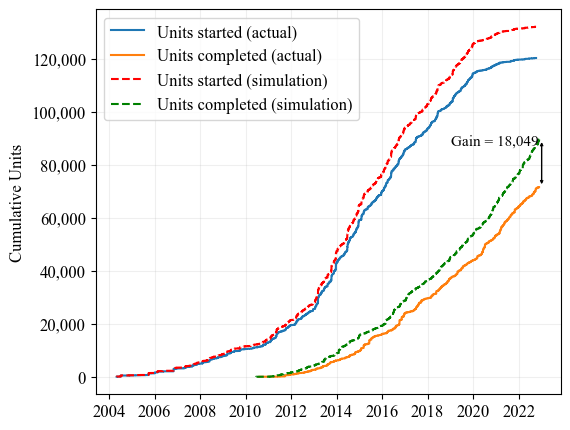

In [16]:
# Add incentive effect to pull forward effect

dfsim['DU_CHANGED_SIM'] = dfsim['DU_CHANGED']*1.098

plot_df1 = dfsim.groupby('START_DATE').agg(TOTAL_ADDED=('DU_CHANGED','sum')).reset_index().sort_values(by='START_DATE', ascending=True)
plot_df1['CUM_ADDED'] = plot_df1['TOTAL_ADDED'].cumsum()

plot_df2 = dfsim.groupby('COFO_DATE').agg(TOTAL_ADDED=('DU_CHANGED','sum')).reset_index().sort_values(by='COFO_DATE', ascending=True)
plot_df2['CUM_ADDED'] = plot_df2['TOTAL_ADDED'].cumsum()

plot_df3 = dfsim.groupby('SIMULATED_COFO').agg(TOTAL_ADDED=('DU_CHANGED_SIM','sum')).reset_index().sort_values(by='SIMULATED_COFO', ascending=True)
plot_df3['CUM_ADDED'] = plot_df3['TOTAL_ADDED'].cumsum()

plot_df4 = dfsim.groupby('START_DATE').agg(TOTAL_ADDED=('DU_CHANGED_SIM','sum')).reset_index().sort_values(by='START_DATE', ascending=True)
plot_df4['CUM_ADDED'] = plot_df4['TOTAL_ADDED'].cumsum()

gapx = plot_df1['START_DATE'].iloc[-1] + pd.to_timedelta(90, unit='D')
gaptop = (gapx, plot_df3['CUM_ADDED'].iloc[-1])
gapbot = (gapx, plot_df2['CUM_ADDED'].iloc[-1])
gap = gaptop[1] - gapbot[1]
gapmid = (gapx, gapbot[1] + 0.5*gap)

plt.figure(figsize=(6,5))
plt.rc('axes', labelsize=12)
plt.step(plot_df1['START_DATE'], plot_df1['CUM_ADDED'])
plt.step(plot_df2['COFO_DATE'], plot_df2['CUM_ADDED'])
plt.step(plot_df4['START_DATE'], plot_df4['CUM_ADDED'], linestyle='dashed', color='red')
plt.step(plot_df3['SIMULATED_COFO'], plot_df3['CUM_ADDED'], linestyle='dashed', color='green')
plt.annotate(text='', xy=gaptop, xytext=gapbot, arrowprops=dict(arrowstyle='<->', mutation_scale=4))
plt.annotate(text=f"Gain = {gap:,.0f}", xy=gapmid, xytext=(-2,16), fontsize=11, textcoords='offset points', ha='right', va='center')
plt.ylabel('Cumulative Units')
plt.legend(['Units started (actual)', 'Units completed (actual)', 'Units started (simulation)', 'Units completed (simulation)'])
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])
plt.grid(alpha=0.2)
plt.gca().set_axisbelow(True)
plt.savefig('../../results/fig_opportunity4.svg', bbox_inches='tight')
plt.show()


C:\Users\ekung\AppData\Local\Temp\ipykernel_9928\3868378471.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_xticks()])


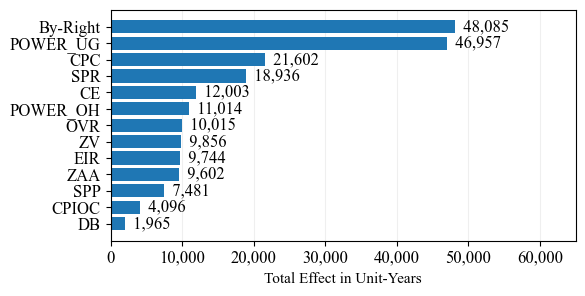

In [6]:
# Salience

coef_df = pd.read_csv("../../intermediate/coefs.csv", index_col=0)

salience_df = []

row = {
    'Variable': 'By-Right', 
    'ApprovalEffect': -coef_df.loc[ 'BY_RIGHTTRUE', 'coef_r2'], 
    'ConstructionEffect': -coef_df.loc[ 'BY_RIGHTTRUE', 'coef_r4'],
    'Effect': -coef_df.loc[ 'BY_RIGHTTRUE', 'effect'],
    'NumProjects': len(dfw.loc[ dfw['N_CASES']>0 ]),
    'NumUnits': dfw.loc[ dfw['N_CASES']>0, 'DU_CHANGED'].sum(),
}
salience_df.append(row)

row = {
    'Variable': 'CPC', 
    'ApprovalEffect': coef_df.loc[ 'CPC', 'coef_r2'], 
    'ConstructionEffect': coef_df.loc[ 'CPC', 'coef_r4'],
    'Effect': coef_df.loc[ 'CPC', 'effect'], 
    'NumProjects': len(dfw.loc[ dfw['pfx_CPC']==1 ]), 
    'NumUnits': dfw.loc[dfw['pfx_CPC']==1, 'DU_CHANGED'].sum()
}
salience_df.append(row)

for var in ['CE','EIR','SPR','SPP','ZAA','ZV','CPIOC','OVR','DB']:
    row = {
        'Variable': var, 
        'ApprovalEffect': coef_df.loc[ var, 'coef_r2'], 
        'ConstructionEffect': coef_df.loc[ var, 'coef_r4'],
        'Effect': coef_df.loc[ var, 'effect'], 
        'NumProjects': len(dfw.loc[ dfw[f"sfx_{var}"]==1]),
        'NumUnits': dfw.loc[dfw[f"sfx_{var}"]==1, 'DU_CHANGED'].sum()
    }
    salience_df.append(row)

for var in ['POWER_OH', 'POWER_UG']:
    row = {
        'Variable': var, 
        'ApprovalEffect': coef_df.loc[ var, 'coef_r2'], 
        'ConstructionEffect': coef_df.loc[ var, 'coef_r4'],
        'Effect': coef_df.loc[ var, 'effect'], 
        'NumProjects': len(dfw.loc[ dfw[f"{var}"]==1]),
        'NumUnits': dfw.loc[dfw[f"{var}"]==1, 'DU_CHANGED'].sum()
    }
    salience_df.append(row)
    
    
salience_df = pd.DataFrame(salience_df)

salience_df['Salience'] = (salience_df['Effect']*salience_df['NumUnits']) / 365.25

salience_df = salience_df.sort_values(by='Salience', ascending=True)

plt.figure(figsize=(6,3))
plt.rc('axes', labelsize=11)
bars = plt.barh(y=salience_df['Variable'], width=salience_df['Salience'])
plt.xlabel('Total Effect in Unit-Years')
plt.bar_label(bars, labels=[f"  {x:,.0f}" for x in bars.datavalues])
plt.xlim(0, 65000)
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_xticks()])
plt.grid(alpha=0.2, axis='x')
plt.gca().set_axisbelow(True)
#plt.savefig('../../results/fig_salience_with_dwp.svg', bbox_inches='tight')
plt.show()


In [7]:
# Simulation helper functions

simdata = pd.read_csv("../../intermediate/data_detailed_sim.csv")
tbl = []
tbl.append(['', 'Total Units', 'Market-Rate Units', 'Affordable Units'])

def simulate(df, DT):
    simdf = df.copy().merge(simdata, on=['PERMIT_NBR'], how='inner')
    simdf['TT'] = simdf['xbetaA'] + simdf['epsA'] + simdf['xbetaC'] + simdf['epsC'] - DT
    simdf['TT'] = simdf['TT'].clip(lower=365.25)
    simdf['SIMULATED_COFO'] = simdf['START_DATE'] + pd.to_timedelta(simdf['TT'],unit='D')

    UNITS_COMPLETED = simdf.loc[simdf['COFO_DATE'].notnull(), 'DU_CHANGED'].sum()
    AFFORDABLE_UNITS_COMPLETED = simdf.loc[simdf['COFO_DATE'].notnull(), 'AFFORDABLE_UNITS'].sum()
    MARKETRATE_UNITS_COMPLETED = UNITS_COMPLETED - AFFORDABLE_UNITS_COMPLETED
    
    UNITS_COMPLETED_SIM = simdf.loc[simdf['SIMULATED_COFO']<=CENSOR_DATE, 'DU_CHANGED'].sum()
    AFFORDABLE_UNITS_COMPLETED_SIM = simdf.loc[simdf['SIMULATED_COFO']<=CENSOR_DATE, 'AFFORDABLE_UNITS'].sum()
    MARKETRATE_UNITS_COMPLETED_SIM = UNITS_COMPLETED_SIM - AFFORDABLE_UNITS_COMPLETED_SIM
    
    GAIN = UNITS_COMPLETED_SIM - UNITS_COMPLETED
    GAIN_AFFORDABLE = AFFORDABLE_UNITS_COMPLETED_SIM - AFFORDABLE_UNITS_COMPLETED
    GAIN_MARKETRATE = MARKETRATE_UNITS_COMPLETED_SIM - MARKETRATE_UNITS_COMPLETED
    
    return {
        'GAIN': GAIN, 
        'GAIN_PCT': GAIN/UNITS_COMPLETED, 
        'GAIN_MARKETRATE': GAIN_MARKETRATE, 
        'GAIN_MARKETRATE_PCT': GAIN_MARKETRATE/MARKETRATE_UNITS_COMPLETED,
        'GAIN_AFFORDABLE': GAIN_AFFORDABLE, 
        'GAIN_AFFORDABLE_PCT': GAIN_AFFORDABLE/AFFORDABLE_UNITS_COMPLETED
    }


C:\Users\ekung\AppData\Local\Temp\ipykernel_9928\1949911687.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])


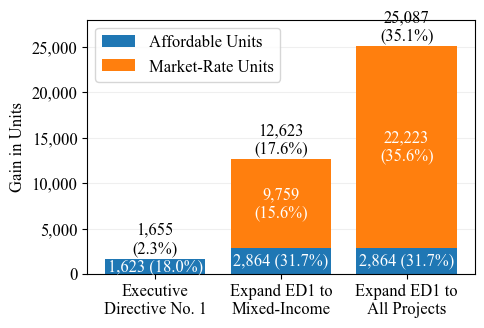

In [8]:
# ED1 simulation

labels = ['Executive\nDirective No. 1', 'Expand ED1 to\nMixed-Income', 'Expand ED1 to\nAll Projects']
eligs = [
    dfw['AFFORDABLE'], 
    (dfw['AFFORDABLE']) | (dfw['MIXEDINCOME']), 
    1
]
gain_tot = []
gain_tot_pct = []
gain_aff = []
gain_aff_pct = []
gain_mkt = []
gain_mkt_pct = []

for i in range(3):
    elig = eligs[i]
    DT = (dfw['PLANCHECK_TIME'] - 60).clip(lower=0)*elig
    DT = DT + coef_df.loc['CPC', 'effect'] * (dfw['pfx_CPC']==1) * elig
    for var in ['SPR']:
        DT = DT + coef_df.loc[var,'effect'] * (dfw[f'sfx_{var}']==1) * elig    
    results = simulate(dfw, DT)
    gain_tot.append(results['GAIN'])
    gain_tot_pct.append(results['GAIN_PCT'])
    gain_aff.append(results['GAIN_AFFORDABLE'])
    gain_aff_pct.append(results['GAIN_AFFORDABLE_PCT'])
    gain_mkt.append(results['GAIN_MARKETRATE'])
    gain_mkt_pct.append(results['GAIN_MARKETRATE_PCT'])
    
plt.figure(figsize=(5,3.3))
plt.rc('axes', labelsize=12)
plt.bar(labels, gain_aff)
plt.bar(labels, gain_mkt, bottom=gain_aff)
for i in range(3):
    plt.text(i, gain_tot[i]+250, f"{gain_tot[i]:,.0f}\n({gain_tot_pct[i]*100:,.1f}%)", ha='center', va='bottom')
    plt.text(i, gain_aff[i]/2, f"{gain_aff[i]:,.0f} ({gain_aff_pct[i]*100:,.1f}%)", ha='center', va='center', color='white')
for i in range(1,3):
    plt.text(i, gain_aff[i] + gain_mkt[i]/2, f"{gain_mkt[i]:,.0f}\n({gain_mkt_pct[i]*100:,.1f}%)", ha='center', va='center', color='white')
    
plt.ylim(0, 28000)
plt.ylabel('Gain in Units')
plt.legend(['Affordable Units', 'Market-Rate Units'])
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])
plt.grid(alpha=0.2, axis='y')
plt.gca().set_axisbelow(True)
#plt.savefig('../../results/fig_ed1_with_dwp.svg', bbox_inches='tight')
plt.show()


C:\Users\ekung\AppData\Local\Temp\ipykernel_9928\3325521095.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])


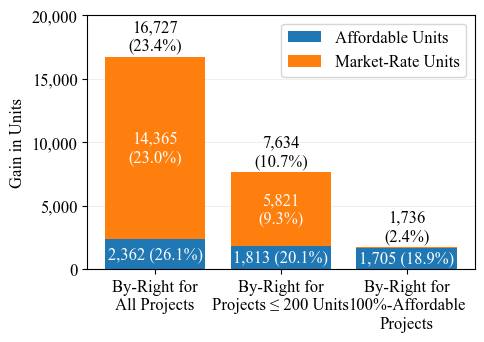

In [9]:
# By-Right Simulations

labels = ['By-Right for\nAll Projects', 'By-Right for\nProjects ≤ 200 Units', 'By-Right for\n100%-Affordable\nProjects']
eligs = [
    1, 
    (dfw['DU_CHANGED']<=200), 
    (dfw['AFFORDABLE'])
]
gain_tot = []
gain_tot_pct = []
gain_aff = []
gain_aff_pct = []
gain_mkt = []
gain_mkt_pct = []

for i in range(3):
    elig = eligs[i]
    DT = -coef_df.loc['BY_RIGHTTRUE','effect'] * (dfw['N_CASES']>0) * elig
    DT = DT + coef_df.loc['CPC', 'effect'] * (dfw['pfx_CPC']==1) * elig
    for var in ['SPR','EIR','MND','CE','SPP','ZAA','ZV','CPIOC','OVR','DB']:
        DT = DT + coef_df.loc[var,'effect'] * (dfw[f'sfx_{var}']==1) * elig    
    results = simulate(dfw, DT)
    gain_tot.append(results['GAIN'])
    gain_tot_pct.append(results['GAIN_PCT'])
    gain_aff.append(results['GAIN_AFFORDABLE'])
    gain_aff_pct.append(results['GAIN_AFFORDABLE_PCT'])
    gain_mkt.append(results['GAIN_MARKETRATE'])
    gain_mkt_pct.append(results['GAIN_MARKETRATE_PCT'])
    
plt.figure(figsize=(5,3.3))
plt.rc('axes', labelsize=12)
plt.bar(labels, gain_aff)
plt.bar(labels, gain_mkt, bottom=gain_aff)
for i in range(3):
    plt.text(i, gain_tot[i]+250, f"{gain_tot[i]:,.0f}\n({gain_tot_pct[i]*100:,.1f}%)", ha='center', va='bottom')
    plt.text(i, gain_aff[i]/2, f"{gain_aff[i]:,.0f} ({gain_aff_pct[i]*100:,.1f}%)", ha='center', va='center', color='white')
for i in range(2):
    plt.text(i, gain_aff[i] + gain_mkt[i]/2, f"{gain_mkt[i]:,.0f}\n({gain_mkt_pct[i]*100:,.1f}%)", ha='center', va='center', color='white')
    
plt.ylim(0, 20000)
plt.ylabel('Gain in Units')
plt.legend(['Affordable Units', 'Market-Rate Units'])
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])
plt.grid(alpha=0.2, axis='y')
plt.gca().set_axisbelow(True)
#plt.savefig('../../results/fig_byright_with_dwp.svg', bbox_inches='tight')
plt.show()


C:\Users\ekung\AppData\Local\Temp\ipykernel_9928\2060579420.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])


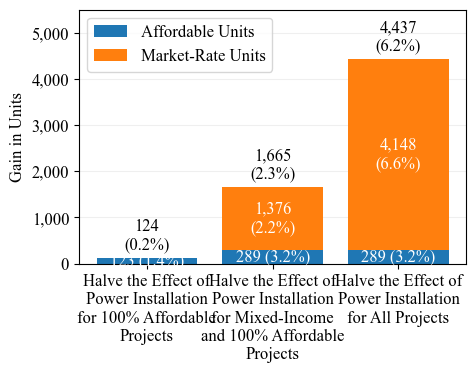

In [10]:
# DWP Simulations

labels = [
    'Halve the Effect of\nPower Installation\nfor 100% Affordable\nProjects',
    'Halve the Effect of\nPower Installation\nfor Mixed-Income\nand 100% Affordable\nProjects',
    'Halve the Effect of\nPower Installation\nfor All Projects',
]
eligs = [
    (dfw['AFFORDABLE']),
    (dfw['AFFORDABLE'] | dfw['MIXEDINCOME']),
    1,
]
gain_tot = []
gain_tot_pct = []
gain_aff = []
gain_aff_pct = []
gain_mkt = []
gain_mkt_pct = []

for i in range(len(eligs)):
    elig = eligs[i]
    ratio = 0.5
    DT = ratio*coef_df.loc['POWER_OH','effect'] * dfw['POWER_OH'] * elig
    DT = DT + ratio*coef_df.loc['POWER_UG','effect'] * dfw['POWER_UG'] * elig
    results = simulate(dfw, DT)
    gain_tot.append(results['GAIN'])
    gain_tot_pct.append(results['GAIN_PCT'])
    gain_aff.append(results['GAIN_AFFORDABLE'])
    gain_aff_pct.append(results['GAIN_AFFORDABLE_PCT'])
    gain_mkt.append(results['GAIN_MARKETRATE'])
    gain_mkt_pct.append(results['GAIN_MARKETRATE_PCT'])
    
plt.figure(figsize=(5,3.3))
plt.rc('axes', labelsize=12)
plt.bar(labels, gain_aff)
plt.bar(labels, gain_mkt, bottom=gain_aff)
for i in range(3):
    plt.text(i, gain_tot[i]+100, f"{gain_tot[i]:,.0f}\n({gain_tot_pct[i]*100:,.1f}%)", ha='center', va='bottom')
    plt.text(i, gain_aff[i]/2, f"{gain_aff[i]:,.0f} ({gain_aff_pct[i]*100:,.1f}%)", ha='center', va='center', color='white')
for i in range(1,3):
    plt.text(i, gain_aff[i] + gain_mkt[i]/2, f"{gain_mkt[i]:,.0f}\n({gain_mkt_pct[i]*100:,.1f}%)", ha='center', va='center', color='white')
    
plt.ylim(0, 5500)
plt.ylabel('Gain in Units')
plt.legend(['Affordable Units', 'Market-Rate Units'])
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])
plt.grid(alpha=0.2, axis='y')
plt.gca().set_axisbelow(True)
#plt.savefig('../../results/fig_dwp_sim.svg', bbox_inches='tight')
plt.show()
